In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Clone this repository in which we have all functions and classes created or adapted to this work.

In [2]:
import os.path

PATH = '/content/drive/MyDrive/grape/'
if os.path.exists(PATH):
    print('grape directory already exists')
else:
    %cd /content/drive/MyDrive/
    !git clone https://github.com/Khubaibakramshirani/grape
    print('Cloning grape in your Drive')

%cd /content/drive/MyDrive/grape/

/content/drive/MyDrive
Cloning into 'grape'...
remote: Enumerating objects: 298, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 298 (delta 91), reused 66 (delta 45), pack-reused 158
Receiving objects: 100% (298/298), 3.35 MiB | 5.04 MiB/s, done.
Resolving deltas: 100% (170/170), done.
Cloning grape in your Drive
/content/drive/MyDrive/grape



Import our algorithms, adapted from deap.algorithms.

Import DEAP.

Import functions used by our grammars.



In [3]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [4]:
!pip install deap

import grape
import algorithms
from functions import not_, and_, or_, nand_, nor_

from os import path
import pandas as pd
import numpy as np
from deap import creator, base, tools

import random
import matplotlib.pyplot as plt

Set our Grammatical Evolution parameters.

In [5]:
POPULATION_SIZE = 500
MAX_GENERATIONS = 50
P_CROSSOVER = 0.8
P_MUTATION = 0.05
ELITE_SIZE = 1 #round(0.01*POPULATION_SIZE) #it should be smaller or equal to HALLOFFAME_SIZE
HALLOFFAME_SIZE = 1 #round(0.01*POPULATION_SIZE) #it should be at least 1

CODON_CONSUMPTION = 'lazy'
GENOME_REPRESENTATION = 'list'
MAX_GENOME_LENGTH = None

MAX_INIT_TREE_DEPTH = 13
MIN_INIT_TREE_DEPTH = 3
MAX_TREE_DEPTH = 35
MAX_WRAPS = 0
CODON_SIZE = 255

REPORT_ITEMS = ['gen', 'invalid', 'avg', 'std', 'min', 'max',
                'best_ind_length', 'avg_length',
                'best_ind_nodes', 'avg_nodes',
                'avg_depth',
                'avg_used_codons', 'best_ind_used_codons',
                'selection_time', 'generation_time']



Set a random seed.

In [6]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)


Notice we read the data in from a file rather than simply generate it. While not strictly necessary, it is a nice piece of functionality that we'll use in later notebooks.

In [7]:

X_train = np.zeros([4,16], dtype=bool)
Y_train = np.zeros([16,], dtype=bool)

data = pd.read_table(r"datasets/parity4.csv")
for i in range(4):
    for j in range(16):
        X_train[i,j] = data['d'+ str(i)].iloc[j]
        #print(X_train[i,j] )
for i in range(16):
    Y_train[i] = data['output'].iloc[i]






Print data.

In [8]:
print(X_train)
print()
print(Y_train)

[[False False False False False False False False  True  True  True  True
   True  True  True  True]
 [False False False False  True  True  True  True False False False False
   True  True  True  True]
 [False False  True  True False False  True  True False False  True  True
  False False  True  True]
 [False  True False  True False  True False  True False  True False  True
  False  True False  True]]

[ True False False  True False  True  True False False  True  True False
  True False False  True]


In [9]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(data)

,d0,d1,d2,d3,output
0,0,0,0,0,1
1,0,0,0,1,0
2,0,0,1,0,0
3,0,0,1,1,1
4,0,1,0,0,0
5,0,1,0,1,1
6,0,1,1,0,1
7,0,1,1,1,0
8,1,0,0,0,0
9,1,0,0,1,1


Print grammar.

Set up the grammar addressed by GRAMMAR_FILE in the class Grammar.

In [10]:
GRAMMAR_FILE1 = 'parity4G1.bnf'
f1 = open("grammars/" + GRAMMAR_FILE1, "r")
print(f1.read())
f1.close()
BNF_GRAMMAR1 = grape.Grammar(path.join("grammars", GRAMMAR_FILE1))


<e>  ::=  <op> | <x>
<op> ::=  and_(<e>,<e>)|
          or_(<e>,<e>)|
          not_(<e>)
<x> ::=   x[0]|x[1]|x[2]|x[3]



Define as fitness function the number of outputs wrongly predicted.

In [11]:
def fitness_eval(individual, points):
    x = points[0]
    Y = points[1]

    if individual.invalid == True:
        return np.NaN,

    # Evaluate the expression
    try:
        pred = eval(individual.phenotype)
    except (FloatingPointError, ZeroDivisionError, OverflowError,
            MemoryError):
        # FP err can happen through eg overflow (lots of pow/exp calls)
        # ZeroDiv can happen when using unprotected operators
        return np.NaN,
    assert np.isrealobj(pred)

    # The expected outputs are in Y
    n_samples = len(Y)
    compare = np.equal(Y,pred) # Compare the outputs with the expected values
    n_correct_outputs = np.sum(compare)

    fitness = n_samples - n_correct_outputs

    return fitness,

Create the deap toolbox.

Use negative weights in the `base.Fitness` since we are trying to minimise the fitness.

`grape.Individual` is a class with the following attributes: `phenotype`, `nodes`, `depth`, `used_codons`, `invalid` (True or False), `n_wraps` and `self.structure`.

`grape.sensible_initialisation` initialises a whole population of GE individuals using Sensible Initialisation.

`tools.selTournament` usef Tournament to select parents.

`grape.crossover_onepoint` selects crossover points within the used portion of the genome.

Similarly, `grape.mutation_int_flip_per_codon` performs only over the effective length.



In [12]:
toolbox = base.Toolbox()

# define a single objective, minimising fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

creator.create('Individual', grape.Individual, fitness=creator.FitnessMin)

toolbox.register("populationCreator", grape.sensible_initialisation, creator.Individual)
#toolbox.register("populationCreator", grape.random_initialisation, creator.Individual)

toolbox.register("evaluate", fitness_eval)

# Tournament selection:
toolbox.register("select", tools.selTournament, tournsize=3)

# Single-point crossover:
toolbox.register("mate", grape.crossover_onepoint)

# Flip-int mutation:
toolbox.register("mutate", grape.mutation_int_flip_per_codon)

Set the main function and run it.

Set the statistics object regarding the fitness score, but there are other statistics defined internally.

Perform Grammatical Evolution using `algorithms.ge_eaSimpleWithElitism`, a simple evolutionary algorithm. The differences to the `algorithms.ge_eaSimpleWithElitism` used by deap are:

*   We use elitism (if you do not want to use, just set ELITISM_SIZE = 0);
*   After crossover and mutation, we check the offspring to assure that the max depth is not violated;
*   We measure many other things to report, such as the generation and the selection times, the number of invalid individuals etc.

In [13]:
# create initial population (generation 0):
population1 = toolbox.populationCreator(pop_size=POPULATION_SIZE,
                                      bnf_grammar=BNF_GRAMMAR1,
                                      min_init_depth=MIN_INIT_TREE_DEPTH,
                                      max_init_depth=MAX_INIT_TREE_DEPTH,
                                      codon_size=CODON_SIZE,
                                      codon_consumption=CODON_CONSUMPTION,
                                      genome_representation=GENOME_REPRESENTATION
                                      )

In [14]:
# define the hall-of-fame object:
hof = tools.HallOfFame(HALLOFFAME_SIZE)

# prepare the statistics object:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.nanmean)
stats.register("std", np.nanstd)
stats.register("min", np.nanmin)
stats.register("max", np.nanmax)

# perform the Grammatical Evolution flow:
population1, logbook1 = algorithms.ge_eaSimpleWithElitism(population1, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                              bnf_grammar=BNF_GRAMMAR1,
                                              codon_size=CODON_SIZE,
                                              max_tree_depth=MAX_TREE_DEPTH,
                                              max_genome_length=MAX_GENOME_LENGTH,
                                              points_train=[X_train, Y_train],
                                              codon_consumption=CODON_CONSUMPTION,
                                              report_items=REPORT_ITEMS,
                                              genome_representation=GENOME_REPRESENTATION,
                                              stats=stats, halloffame=hof, verbose=False)



gen = 0 , Best fitness = (6.0,)
gen = 1 , Best fitness = (6.0,) , Number of invalids = 91
gen = 2 , Best fitness = (6.0,) , Number of invalids = 64
gen = 3 , Best fitness = (6.0,) , Number of invalids = 43
gen = 4 , Best fitness = (6.0,) , Number of invalids = 30
gen = 5 , Best fitness = (6.0,) , Number of invalids = 27
gen = 6 , Best fitness = (6.0,) , Number of invalids = 19
gen = 7 , Best fitness = (6.0,) , Number of invalids = 20
gen = 8 , Best fitness = (6.0,) , Number of invalids = 16
gen = 9 , Best fitness = (6.0,) , Number of invalids = 13
gen = 10 , Best fitness = (6.0,) , Number of invalids = 14
gen = 11 , Best fitness = (6.0,) , Number of invalids = 13
gen = 12 , Best fitness = (6.0,) , Number of invalids = 7
gen = 13 , Best fitness = (6.0,) , Number of invalids = 12
gen = 14 , Best fitness = (6.0,) , Number of invalids = 8
gen = 15 , Best fitness = (6.0,) , Number of invalids = 13
gen = 16 , Best fitness = (6.0,) , Number of invalids = 7
gen = 17 , Best fitness = (6.0,) , N

Extract statistics and build a nice looking table.

In [15]:
max_fitness_values, mean_fitness_values = logbook1.select("max", "avg")
min_fitness_values, std_fitness_values = logbook1.select("min", "std")

best_ind_length = logbook1.select("best_ind_length")
avg_length = logbook1.select("avg_length")

selection_time = logbook1.select("selection_time")
generation_time = logbook1.select("generation_time")
gen, invalid = logbook1.select("gen", "invalid")
avg_used_codons = logbook1.select("avg_used_codons")
best_ind_used_codons = logbook1.select("best_ind_used_codons")

best_ind_nodes = logbook1.select("best_ind_nodes")
avg_nodes = logbook1.select("avg_nodes")

avg_depth = logbook1.select("avg_depth")

header = REPORT_ITEMS

results = pd.DataFrame(list(zip(gen, invalid, mean_fitness_values, std_fitness_values,
                                min_fitness_values, max_fitness_values,
                                best_ind_length, avg_length,
                                best_ind_nodes, avg_nodes,
                                avg_depth,
                                avg_used_codons, best_ind_used_codons,
                                selection_time, generation_time)),
               columns = header)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(results)

,gen,invalid,avg,std,min,max,best_ind_length,avg_length,best_ind_nodes,avg_nodes,avg_depth,avg_used_codons,best_ind_used_codons,selection_time,generation_time
0,0,0,7.982000,0.360106,6.0,9.0,126,50.568000,19,7.350000,8.748000,33.712000,84,0.000000,0.087767
1,1,91,7.977995,0.398045,6.0,10.0,126,62.080685,19,6.132029,9.767726,27.555012,84,0.003829,0.619114
2,2,64,7.965596,0.326519,6.0,9.0,126,71.318807,19,5.282110,9.697248,23.220183,84,0.003918,0.468152
3,3,43,7.960613,0.354067,6.0,9.0,126,78.954048,19,5.072210,9.971554,22.455142,84,0.010323,0.537574
4,4,30,7.942553,0.337226,6.0,9.0,126,83.302128,19,4.827660,9.561702,20.902128,84,0.003771,0.314902
5,5,27,7.978858,0.394970,6.0,9.0,126,87.890063,19,5.177590,10.133192,22.448203,84,0.003548,0.341405
6,6,19,7.954262,0.361890,6.0,9.0,126,90.760915,19,5.214137,10.384615,22.677755,84,0.003746,0.299719
7,7,20,7.958333,0.351090,6.0,9.0,126,98.008333,19,5.618750,10.737500,24.400000,84,0.001940,0.171160
8,8,16,7.962810,0.350120,6.0,9.0,126,102.411157,19,6.030992,11.020661,26.318182,84,0.001942,0.224379
9,9,13,7.948665,0.378359,6.0,10.0,126,105.178645,19,5.800821,11.020534,25.367556,84,0.001903,0.182466


Show the best individual as an expression.

In [16]:
import textwrap
best = hof.items[0].phenotype
print("Best individual: \n","\n".join(textwrap.wrap(best,80)))
print("\nTraining Fitness: ", hof.items[0].fitness.values[0])

print("Depth: ", hof.items[0].depth)
print("Length of the genome: ", len(hof.items[0].genome))
print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')

Best individual: 
 or_(not_(or_(or_(or_(x[1],x[0]),or_(x[3],x[3])),or_(and_(x[2],x[2]),or_(x[2],x[1
])))),and_(or_(and_(and_(x[0],x[0]),not_(x[3])),not_(not_(x[0]))),and_(or_(not_(
x[1]),and_(x[2],x[3])),or_(x[3],and_(or_(x[3],and_(x[2],x[0])),not_(or_(and_(x[2
],x[3]),not_(x[2]))))))))

Training Fitness:  5.0
Depth:  19
Length of the genome:  149
Used portion of the genome: 0.67


Plot graphs regarding the best fitness and the average fitness.

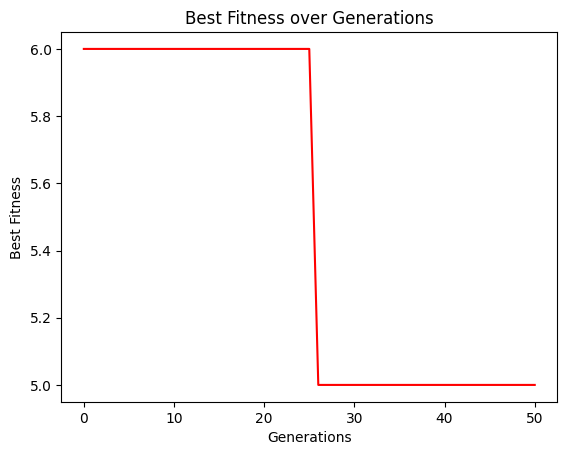

In [17]:
plt.plot(min_fitness_values, color='red')
plt.xlabel('Generations')
plt.ylabel('Best Fitness')
plt.title('Best Fitness over Generations')
plt.show()

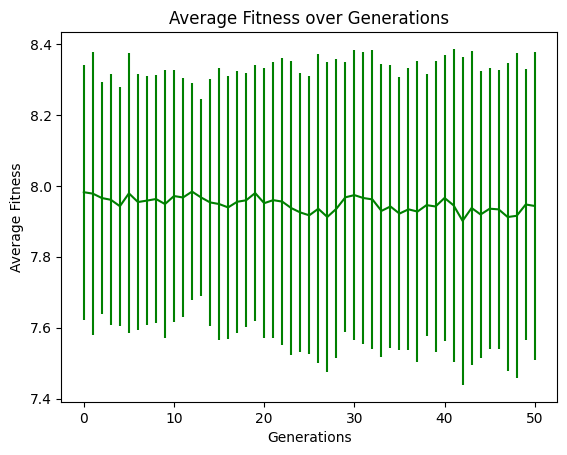

In [18]:
gen = np.arange(0, 50+1)

plt.xlabel('Generations')
plt.ylabel('Average Fitness')
plt.title('Average Fitness over Generations')
plt.errorbar(gen, mean_fitness_values, yerr=std_fitness_values,label="Best", color="Green")
plt.show()

Plot graphs regarding the length of the genome: the average of the population and that one of the best individual.


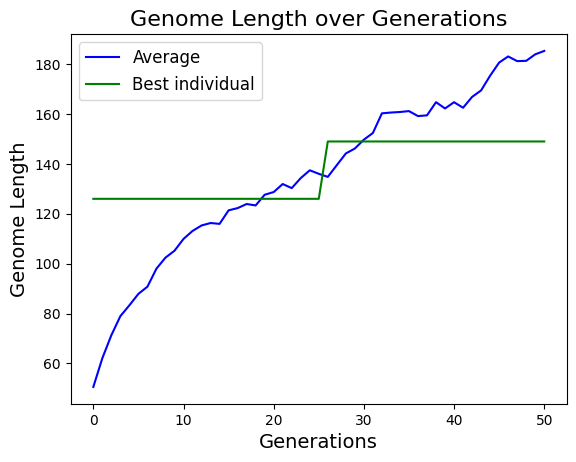

In [19]:
plt.plot(gen, avg_length, color='blue', label="Average")
plt.plot(gen, best_ind_length, color='green', label="Best individual")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Genome Length', fontsize=14)
plt.title('Genome Length over Generations', fontsize=16)
plt.show()

##Grammar with File Parity4G2

In [20]:
#----------------------------------------------
GRAMMAR_FILE2 = 'parity4G2.bnf'
f2 = open("grammars/" + GRAMMAR_FILE2, "r")
print(f2.read())
f2.close()
BNF_GRAMMAR2 = grape.Grammar(path.join("grammars", GRAMMAR_FILE2))

<e>  ::=  <op> | <x>
<op> ::=  and_(<e>,<e>)|
          or_(<e>,<e>)
<x> ::=   x[0]|x[1]|x[2]|x[3]



In [21]:
population2 = toolbox.populationCreator(pop_size=POPULATION_SIZE,
                                      bnf_grammar=BNF_GRAMMAR2,
                                      min_init_depth=MIN_INIT_TREE_DEPTH,
                                      max_init_depth=MAX_INIT_TREE_DEPTH,
                                      codon_size=CODON_SIZE,
                                      codon_consumption=CODON_CONSUMPTION,
                                      genome_representation=GENOME_REPRESENTATION
                                      )
population2, logbook2 = algorithms.ge_eaSimpleWithElitism(population2, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                              bnf_grammar=BNF_GRAMMAR2,
                                              codon_size=CODON_SIZE,
                                              max_tree_depth=MAX_TREE_DEPTH,
                                              max_genome_length=MAX_GENOME_LENGTH,
                                              points_train=[X_train, Y_train],
                                              codon_consumption=CODON_CONSUMPTION,
                                              report_items=REPORT_ITEMS,
                                              genome_representation=GENOME_REPRESENTATION,
                                              stats=stats, halloffame=hof, verbose=False)

max_fitness_values2, mean_fitness_values2 = logbook2.select("max", "avg")
min_fitness_values2, std_fitness_values2 = logbook2.select("min", "std")

best_ind_length2 = logbook2.select("best_ind_length")
avg_length2 = logbook2.select("avg_length")

selection_time2 = logbook2.select("selection_time")
generation_time2 = logbook2.select("generation_time")
gen2, invalid2 = logbook2.select("gen", "invalid")
avg_used_codons2 = logbook2.select("avg_used_codons")
best_ind_used_codons2 = logbook2.select("best_ind_used_codons")

best_ind_nodes2 = logbook2.select("best_ind_nodes")
avg_nodes2 = logbook2.select("avg_nodes")

avg_depth2 = logbook2.select("avg_depth")

header2 = REPORT_ITEMS

results2 = pd.DataFrame(list(zip(gen2, invalid2, mean_fitness_values2, std_fitness_values2,
                                min_fitness_values2, max_fitness_values2,
                                best_ind_length2, avg_length2,
                                best_ind_nodes2, avg_nodes2,
                                avg_depth2,
                                avg_used_codons2, best_ind_used_codons2,
                                selection_time2, generation_time2)),
                        columns = header2)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(results2)

gen = 0 , Best fitness = (5.0,)
gen = 1 , Best fitness = (5.0,) , Number of invalids = 86
gen = 2 , Best fitness = (5.0,) , Number of invalids = 82
gen = 3 , Best fitness = (5.0,) , Number of invalids = 42
gen = 4 , Best fitness = (5.0,) , Number of invalids = 41
gen = 5 , Best fitness = (5.0,) , Number of invalids = 37
gen = 6 , Best fitness = (5.0,) , Number of invalids = 23
gen = 7 , Best fitness = (5.0,) , Number of invalids = 30
gen = 8 , Best fitness = (5.0,) , Number of invalids = 14
gen = 9 , Best fitness = (5.0,) , Number of invalids = 12
gen = 10 , Best fitness = (5.0,) , Number of invalids = 11
gen = 11 , Best fitness = (5.0,) , Number of invalids = 16
gen = 12 , Best fitness = (5.0,) , Number of invalids = 17
gen = 13 , Best fitness = (5.0,) , Number of invalids = 6
gen = 14 , Best fitness = (5.0,) , Number of invalids = 14
gen = 15 , Best fitness = (5.0,) , Number of invalids = 8
gen = 16 , Best fitness = (5.0,) , Number of invalids = 5
gen = 17 , Best fitness = (5.0,) , N

,gen,invalid,avg,std,min,max,best_ind_length,avg_length,best_ind_nodes,avg_nodes,avg_depth,avg_used_codons,best_ind_used_codons,selection_time,generation_time
0,0,0,7.986000,0.658638,5.0,10.0,149,101.844000,22,17.474000,8.928000,67.896000,100,0.000000,0.123178
1,1,86,7.896135,0.586758,5.0,10.0,149,124.050725,22,12.541063,10.212560,48.198068,100,0.014049,0.888445
2,2,82,7.870813,0.529114,5.0,10.0,149,149.813397,22,12.696172,11.751196,48.818182,100,0.003933,0.867673
3,3,42,7.893013,0.536359,5.0,10.0,149,166.681223,22,12.366812,12.541485,47.497817,100,0.003808,0.721641
4,4,41,7.877996,0.546663,5.0,10.0,149,168.485839,22,13.037037,13.601307,50.178649,100,0.003813,0.855670
5,5,37,7.881210,0.465822,5.0,9.0,149,173.431965,22,12.501080,13.898488,48.034557,100,0.010015,0.645638
6,6,23,7.909853,0.486987,5.0,9.0,149,191.607966,22,12.838574,14.610063,49.383648,100,0.001966,0.420954
7,7,30,7.910638,0.493030,5.0,10.0,149,197.357447,22,11.612766,13.863830,44.480851,100,0.001898,0.380364
8,8,14,7.913580,0.480848,5.0,9.0,149,208.687243,22,11.526749,13.744856,44.135802,100,0.001911,0.365326
9,9,12,7.926230,0.514830,5.0,10.0,149,215.631148,22,11.065574,13.672131,42.290984,100,0.001940,0.346004


In [22]:
import textwrap
best = hof.items[0].phenotype
print("Best individual: \n","\n".join(textwrap.wrap(best,80)))
print("\nTraining Fitness: ", hof.items[0].fitness.values[0])

print("Depth: ", hof.items[0].depth)
print("Length of the genome: ", len(hof.items[0].genome))
print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')

Best individual: 
 or_(not_(or_(or_(or_(x[1],x[0]),or_(x[3],x[3])),or_(and_(x[2],x[2]),or_(x[2],x[1
])))),and_(or_(and_(and_(x[0],x[0]),not_(x[3])),not_(not_(x[0]))),and_(or_(not_(
x[1]),and_(x[2],x[3])),or_(x[3],and_(or_(x[3],and_(x[2],x[0])),not_(or_(and_(x[2
],x[3]),not_(x[2]))))))))

Training Fitness:  5.0
Depth:  19
Length of the genome:  149
Used portion of the genome: 0.67


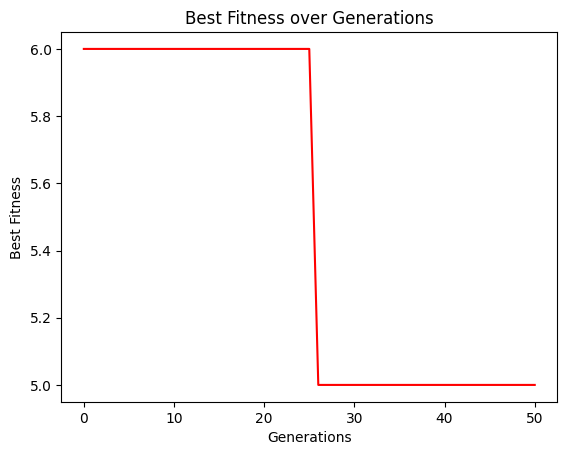

In [23]:
plt.plot(min_fitness_values, color='red')
plt.xlabel('Generations')
plt.ylabel('Best Fitness')
plt.title('Best Fitness over Generations')
plt.show()


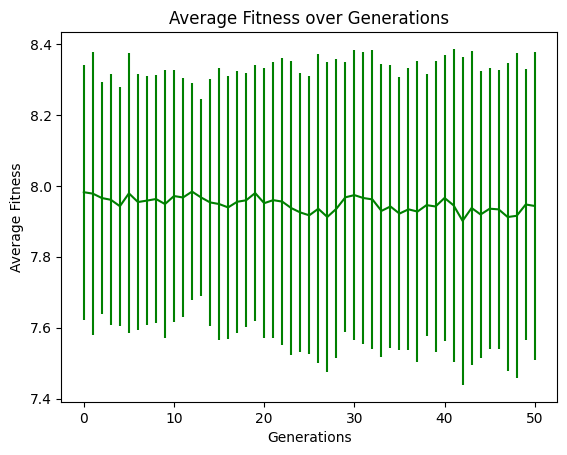

In [24]:
gen = np.arange(0, 50+1)

plt.xlabel('Generations')
plt.ylabel('Average Fitness')
plt.title('Average Fitness over Generations')
plt.errorbar(gen, mean_fitness_values, yerr=std_fitness_values,label="Best", color="Green")
plt.show()

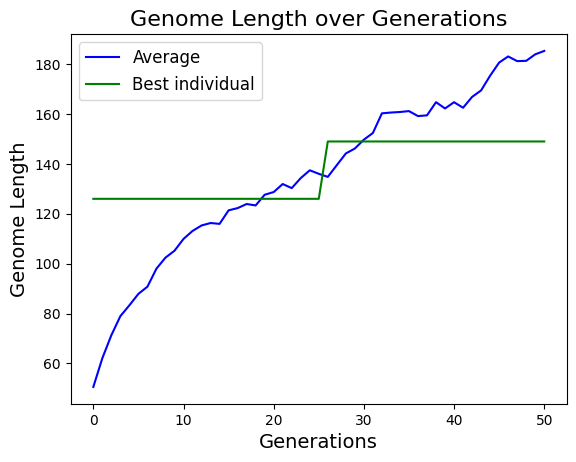

In [25]:
plt.plot(gen, avg_length, color='blue', label="Average")
plt.plot(gen, best_ind_length, color='green', label="Best individual")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Genome Length', fontsize=14)
plt.title('Genome Length over Generations', fontsize=16)
plt.show()

#Comparison

**Pset 1 using GP Best Individual**

-- ***Best Individual =***  and_(or_(and_(and_(or_(ARG3, ARG0), and_(ARG3, or_(ARG3, ARG0))), and_(or_(or_(ARG1, ARG1), or_(ARG1, ARG0)), and_(and_(or_(ARG1, ARG1), ARG0), or_(ARG3, ARG0)))), and_(or_(and_(ARG1, ARG3), and_(ARG0, ARG2)), or_(and_(ARG2, ARG2), and_(ARG1, ARG2)))), or_(or_(or_(and_(ARG1, ARG2), ARG1), and_(and_(ARG2, ARG2), and_(ARG3, ARG3))), and_(or_(ARG3, and_(ARG3, ARG2)), ARG3)))

-- **length**=65, **height**=7

-- **Best Fitness** =  5.0

------------------
**Pset 1 using GE Best Individual**


**Best individual: **
Best individual:
  or_(not_(or_(or_(or_(x[1],x[0]),or_(x[3],x[3])),or_(and_(x[2],x[2]),or_(x[2],x[1])))),and_(or_(and_(and_(x[0],x[0]),not_(x[3])),not_(not_(x[0]))),and_(or_(not_(x[1]),and_(x[2],x[3])),or_(x[3],and_(or_(x[3],and_(x[2],x[0])),not_(or_(and_(x[2],x[3]),not_(x[2]))))))))

**Training Fitness: ** 5.0
**Depth**:  19
**Length of the genome:**  149
**Used portion of the genome:** 0.67




##**P-Set two**

###**GP**

-- ***Best Individual =**

and_(or_(and_(and_(or_(or_(ARG3, and_(and_(ARG1, ARG2), or_(and_(or_(ARG3, ARG1), ARG1), or_(ARG3, ARG3)))), not_(ARG0)), or_(and_(ARG3, ARG0), or_(and_(ARG1, ARG1), and_(and_(or_(ARG1, or_(ARG3, not_(not_(ARG2)))), ARG2), or_(ARG3, not_(or_(not_(ARG3), or_(ARG2, not_(ARG3))))))))), or_(not_(and_(ARG3, or_(or_(ARG1, or_(or_(ARG3, ARG1), or_(or_(ARG2, ARG0), ARG3))), ARG0))), ARG2)), and_(or_(not_(and_(or_(or_(ARG3, ARG1), not_(ARG2)), or_(and_(ARG3, ARG0), and_(ARG2, ARG1)))), not_(ARG0)), and_(or_(ARG1, or_(ARG3, not_(not_(ARG0)))), not_(or_(ARG2, ARG1))))), or_(not_(and_(and_(or_(not_(not_(ARG3)), ARG1), or_(not_(not_(or_(and_(not_(and_(and_(ARG0, ARG2), ARG0)), or_(and_(and_(or_(or_(ARG1, ARG0), not_(ARG3)), not_(not_(ARG2))), ARG2), not_(or_(ARG1, not_(ARG3))))), and_(or_(and_(or_(ARG0, ARG3), and_(ARG1, ARG2)), not_(not_(ARG2))), or_(ARG1, ARG1))))), not_(or_(ARG2, or_(ARG1, ARG3))))), ARG2)), or_(and_(ARG1, ARG3), and_(and_(ARG2, or_(and_(or_(ARG3, ARG1), and_(or_(ARG1, not_(ARG2)), or_(and_(ARG1, ARG0), and_(ARG2, ARG1)))), and_(or_(not_(ARG2), ARG3), ARG3))), ARG0))))

-- **length**=190, **height**=15

-- **Best Fitness** =  3.0

-------------
###**GE**

**Best individual:**

or_(not_(or_(or_(or_(x[1],x[0]),or_(x[3],x[3])),or_(and_(x[2],x[2]),or_(x[2],x[1])))),and_(or_(and_(and_(x[0],x[0]),not_(x[3])),not_(not_(x[0]))),and_(or_(not_(x[1]),and_(x[2],x[3])),or_(x[3],and_(or_(x[3],and_(x[2],x[0])),not_(or_(and_(x[2],x[3]),not_(x[2]))))))))

**Training Fitness: ** 5.0
**Depth**:  19
**Length of the genome:**  149
**Used portion of the genome:** 0.67

